In [1]:
%config ZMQInteractiveShell.ast_node_interactivity = "all"
%pprint

Pretty printing has been turned OFF


In [2]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torchsummary import summary
sys.path.append("../d2l_func/")
from data_prepare import download_data_fashion_mnist, load_data_fashion_mnist
from model_train import train_epoch

## ResNet

我们的目标是输入x，学到映射f(x)，ResNet指出先学到残差映射`f(x) - x`(更容易学到)，再通过残差连接`(f(x) - x) + x`得到f(x)
- 残差模块一般包括两个3x3的卷积核，和可选的1x1卷积核（用于改变通道，获取空间信息），和GoogleNet有点不同的是，在3x3卷积核后面加上BN层，此时可以保证输入和输出的维度一样，以便于进行残差连接

### 残差模块

In [3]:
class Residual(nn.Module):
    """
    function: realize the Residual Module
    """
    def __init__(self, in_channels, out_channels, use_1x1=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        # if use_1x1 conv, we define a 1x1 conv
        if use_1x1:
            self.conv3 = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride)
            )
        else:
            self.conv3 = None
        # if not use 1x1 conv, add relu after conv2. otherwise, add relu after conv3.
        self.relu = nn.ReLU()
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        # use 1x1 conv
        if self.conv3:
            x = self.conv3(x)
        return self.relu(output + x)

测试

In [4]:
blk = Residual(3, 3)
x = torch.rand(4, 3, 6, 6)
blk(x).shape

torch.Size([4, 3, 6, 6])

In [5]:
blk = Residual(3, 6, True, 2)
blk(x).shape

torch.Size([4, 6, 3, 3])

### 模型

ResNet和GoogleNet一样，先使用64个输出通道，stride=2, padding=3的卷积核，然后再接上3x3, stride=2的overlapping 最大池化，有点不一样的是，ResNet在每个卷积层后面加上BN

和GoogleNet（接了4个Inception组成的模块）一样，ResNet后面也使用由4个由残差块组成的模块，每个模块使用若干个同样输出通道的残差块，第一个模块的通道数和输入通道数一样，因为之前使用过stride=2的最大池化，所以第一个模块不用减高宽，之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高宽减半

每个模块使用两个残差块

In [6]:
def residual_block(in_channels, out_channels, res_num, first_block=False):
    """
    function: realize residual_block which has two Residual Module
    params in_channels: the channels of input
    params out_channels: the channels of output
    params res_num: the number of residual module
    params first_block: if the first block, the in_channels is equal to out_channels
    """
    blk = []
    if first_block:
        assert in_channels == out_channels
        
    for num in range(res_num):
        # Except the first block, the first Residual in each block use 1x1 conv, stride=2
        if num == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1=True, stride=2))
        else:
            blk.append(Residual(out_channels, out_channels))
        
    return nn.Sequential(*blk)

In [7]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)
    

class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
        
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])

    
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.layer = nn.Sequential(OrderedDict({
            "block1": nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, padding=3, stride=2),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                # overlapping max pool
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            ),
            
            "block2": residual_block(64, 64, 2, first_block=True),
            "block3": residual_block(64, 128, 2),
            "block4": residual_block(128, 256, 2),
            "block5": residual_block(256, 512, 2),
            # output shape (Batch, 512, 1, 1)
            "global_avg_pool": GlobalAvgPool2d(),
            "fc": nn.Sequential(
                FlattenLayer(),
                nn.Linear(512, 10)
            )
        }))
        
    def forward(self, x):
        return self.layer(x)
    
    def score(self, x, y):
        y_pred = self.forward(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

In [12]:
# 打印网络结构
model = ResNet()
model = model.cuda()
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
         Residual-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch [1/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5510, train_score: 0.717, test_loss: 0.3688, test_score: 0.866

Epoch [2/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3018, train_score: 0.860, test_loss: 0.3201, test_score: 0.886

Epoch [3/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2441, train_score: 0.904, test_loss: 0.2386, test_score: 0.917

Epoch [4/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2139, train_score: 0.918, test_loss: 0.2411, test_score: 0.915

Epoch [5/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1881, train_score: 0.928, test_loss: 0.2465, test_score: 0.914

Epoch [6/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1642, train_score: 0.939, test_loss: 0.2288, test_score: 0.920

Epoch [7/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1418, train_score: 0.946, test_loss: 0.2250, test_score: 0.922

Epoch [8/15]
60000/60000 [>>>>>>>>

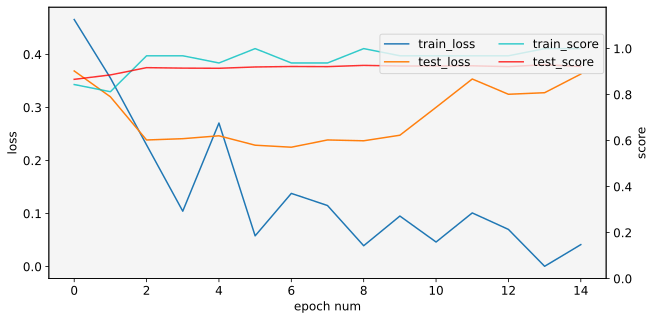

execute time is 2460.072 seconds


In [10]:
# define model
model = ResNet()
model = model.cuda()
# loss
loss = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

# params
params = {
    "epoch_num": 15,
    "data_num": len(mnist_train),
    "model": model,
    "loss": loss,
    "batch_size": 64,
    "optimizer": optimizer,
    "evaluate": model.score,
    "gpu": True,
    "draw": True,
    "save_fig": True,
    "save_path": "../result/ResetNet实验/img/"
}
train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8, resize=224)
params["train_iter"] = train_iter
params["test_iter"] = test_iter

# training
train_epoch(**params)

Epoch [1/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4356, train_score: 0.785, test_loss: 0.4392, test_score: 0.842

Epoch [2/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2493, train_score: 0.902, test_loss: 0.2925, test_score: 0.896

Epoch [3/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2022, train_score: 0.924, test_loss: 0.2319, test_score: 0.916

Epoch [4/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1642, train_score: 0.938, test_loss: 0.2095, test_score: 0.926

Epoch [5/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1350, train_score: 0.947, test_loss: 0.2197, test_score: 0.925

Epoch [6/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1082, train_score: 0.956, test_loss: 0.2614, test_score: 0.914

Epoch [7/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.0820, train_score: 0.967, test_loss: 0.2407, test_score: 0.922

Epoch [8/15]
60000/60000 [>>>>>>>>

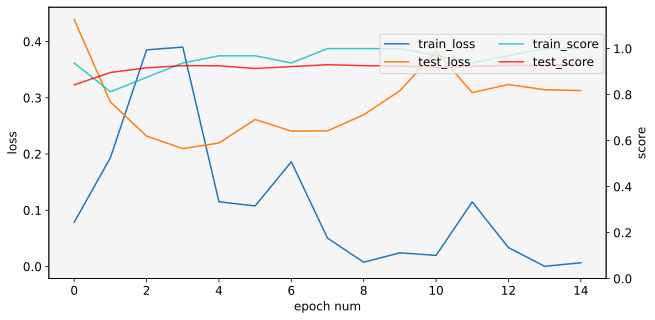

execute time is 2439.450 seconds


In [11]:
# define model
model = ResNet()
model = model.cuda()
# loss
loss = nn.CrossEntropyLoss()
# optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

# params
params = {
    "epoch_num": 15,
    "data_num": len(mnist_train),
    "model": model,
    "loss": loss,
    "batch_size": 64,
    "optimizer": optimizer,
    "evaluate": model.score,
    "gpu": True,
    "draw": True,
    "save_fig": True,
    "save_path": "../result/ResetNet实验/img/"
}
train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8, resize=224)
params["train_iter"] = train_iter
params["test_iter"] = test_iter

# training
train_epoch(**params)

## DenseNet

DenseNet又称稠密神经网络，与ResNet神经网络不同的是，残差连接改成在通道上的连接，而且这种连接不限于在稠密块的输入和输出之间，还应用在稠密块内部卷积块，即输入和各卷积块也进行通道的连接
- ResNet的残差连接是应用在残差块的输入和输出之间
- 这里像ResNet一样，DenseNet先经过一个64x1x7x7的卷积层（加BN），然后经过4个稠密块(每个稠密块有4个卷积层)，后面接着全局最大池化和fc
- ResNet是通过stride来减少高宽，而DenseNet为了降低模型的复杂度，增加过渡层，使用1x1的卷积来减少通道数，使用stride=2的平均池化来减少高宽

### 稠密块

In [3]:
def conv_block(in_channels, out_channels):
    blk = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
    )
    return blk

In [4]:
class DenseBlock(nn.Module):
    """
    function: realize DenseBlock in DenseNet
    params in_channels: the number of channels in input 
    params out_channels: Actually, the out_channels stands for the growth rate of concat, 
                         when concatenate the conv_block in DenseBlock
    params num_conv: the number of conv layer in a DenseBlock
    """
    def __init__(self, in_channels, out_channels, num_conv):
        super(DenseBlock, self).__init__()
        block = []
        for num in range(num_conv):
            in_c = in_channels + num * out_channels
            block.append(conv_block(in_c, out_channels))
        self.block = nn.ModuleList(block)
        # calculate the number of channels
        self.out_channels = in_channels + num_conv * out_channels
    
    def forward(self, x):
        for blk in self.block:
            y = blk(x)
            # concat in channels
            x = torch.cat((x, y), dim=1)
        return x

测试

In [15]:
blk = DenseBlock(3, 10, 2)
blk
x = torch.rand(4, 3, 8, 8)
y = blk(x)
y.shape

DenseBlock(
  (block): ModuleList(
    (0): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Sequential(
      (0): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(13, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

torch.Size([4, 23, 8, 8])

### 过渡块

In [5]:
def transition_block(in_channels, out_channels):
    blk = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=1),
        nn.AvgPool2d(2)
    )
    return blk

In [17]:
# 过渡块验证，使用1x1 conv来改变通道数，平均池化来减少高宽
blk = transition_block(23, 10)
# 从通道23到10, 高宽从8到4
blk(y).shape

torch.Size([4, 10, 4, 4])

In [6]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)
    

class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
        
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])

net = nn.Sequential()
# block1
net.add_module("block1", nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, padding=3, stride=2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(3, padding=1, stride=2),
))
# dense_block and transition block
in_channels, growth_channels = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]

for i, num_convs in enumerate(num_convs_in_dense_blocks):
    # DenseBlock
    dense_block = DenseBlock(in_channels, growth_channels, num_convs)
    net.add_module("den_block%d" %(i+2), dense_block)
    in_channels = dense_block.out_channels
    
    # transition block
    # In the last dense_block, we not add transition block
    if i != (len(num_convs_in_dense_blocks) - 1):
        net.add_module("trans_block%d" %(i+2), transition_block(in_channels, in_channels//2))
        in_channels = in_channels // 2
        
# bn
net.add_module("bn", nn.BatchNorm2d(in_channels))
net.add_module("relu", nn.ReLU())
net.add_module("gapool", GlobalAvgPool2d())
net.add_module("fc", nn.Sequential(FlattenLayer(), nn.Linear(in_channels, 10)))

In [7]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.net = net
        
    def forward(self, x):
        return self.net(x)
    
    def score(self, x, y):
        y_pred = self.forward(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

In [37]:
model = DenseNet()
model = model.cuda()
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]          18,464
       BatchNorm2d-8           [-1, 96, 56, 56]             192
              ReLU-9           [-1, 96, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          27,680
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13           [-1, 32, 56, 56]          36,896
      BatchNorm2d-14          [-1, 160,

Epoch [1/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.7935, train_score: 0.692, test_loss: 0.4986, test_score: 0.818

Epoch [2/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3937, train_score: 0.831, test_loss: 0.4783, test_score: 0.820

Epoch [3/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3207, train_score: 0.863, test_loss: 0.4079, test_score: 0.847

Epoch [4/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2787, train_score: 0.887, test_loss: 0.3277, test_score: 0.889

Epoch [5/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2505, train_score: 0.901, test_loss: 0.4496, test_score: 0.827

Epoch [6/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2314, train_score: 0.913, test_loss: 0.2575, test_score: 0.910

Epoch [7/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2152, train_score: 0.920, test_loss: 0.2396, test_score: 0.914

Epoch [8/15]
60000/60000 [>>>>>>>>

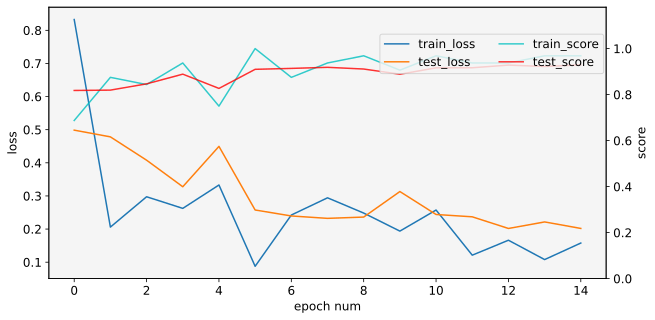

execute time is 2249.375 seconds


In [8]:
# define model
model = DenseNet()
model = model.cuda()
# loss
loss = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

# params
params = {
    "epoch_num": 15,
    "data_num": len(mnist_train),
    "model": model,
    "loss": loss,
    "batch_size": 64,
    "optimizer": optimizer,
    "evaluate": model.score,
    "gpu": True,
    "draw": True,
    "save_fig": True,
    "save_path": "../result/DenseNet实验/img/"
}
train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8, resize=224)
params["train_iter"] = train_iter
params["test_iter"] = test_iter

# training
train_epoch(**params)